In [2]:
import tensorflow as tf
from skimage.feature import hog
from skimage import io, transform
from sklearn.model_selection import train_test_split
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

2024-04-23 16:11:33.661758: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 16:11:33.682894: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 16:11:33.682915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 16:11:33.683495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 16:11:33.686781: I tensorflow/core/platform/cpu_feature_guar

In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label, label_folder in enumerate(['Benign cases', 'Malignant cases', 'Normal cases']):
        path = os.path.join(folder, label_folder)
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = io.imread(img_path, as_gray=True)
            if img is not None:
                img = transform.resize(img, (100, 100))   
                hog_features = hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), transform_sqrt=True, block_norm='L2-Hys')             
                images.append(hog_features)
                labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
data_folder = 'The IQ-OTHNCCD lung cancer dataset'
images, labels = load_images_from_folder(data_folder)

X = np.array(images)
y = np.array(labels)

In [5]:
X.shape

(2073, 4356)

In [6]:

class_counts = {'Benign': 0, 'Malignant': 0, 'Normal': 0}

# Map labels to class names
label_to_class = {0: 'Benign', 1: 'Malignant', 2: 'Normal'}

# Count the number of images per class
for label in labels:
    class_name = label_to_class[label]
    class_counts[class_name] += 1

print("Number of images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


Number of images per class:
Benign: 120
Malignant: 1339
Normal: 614


In [7]:
y = to_categorical(y, num_classes=3)

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [9]:
X_train.shape

(1451, 4356)

In [10]:
X_train = X_train.reshape(X_train.shape[0], 1, -1)
X_val = X_val.reshape(X_val.shape[0], 1, -1)
X_test = X_test.reshape(X_test.shape[0], 1, -1)

single = X_test[0]

In [11]:
X_train.shape[2]

4356

In [12]:
from tensorflow.keras.layers import Dense, LSTM

In [13]:
model = tf.keras.models.Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(3, activation='softmax')
])

2024-04-23 16:11:51.125421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 16:11:51.147920: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 16:11:51.155642: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

from sklearn.utils import compute_class_weight
classWeight = compute_class_weight('balanced', outputLabels, outputs) 
classWeight = dict(enumerate(classWeight))
model.fit(X_train, y_train, batch_size = 32, epochs = 50, show_accuracy = True, verbose = 2, validation_data = (X_test, y_test), class_weight=classWeight)

In [36]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/10
33/46 [====================>.........] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.98071, saving model to best_model.keras
46/46 [==============================] - 0s 4ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0491 - val_accuracy: 0.9807
Epoch 2/10
31/46 [===================>..........] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.98071 to 0.98392, saving model to best_model.keras
46/46 [==============================] - 0s 5ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0486 - val_accuracy: 0.9839
Epoch 3/10
39/46 [========================>.....] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.98392
46/46 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0517 - val_accuracy: 0.9807
Epoch 4/10
40/46 [=========================>....] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000
Epoch 4: va

In [19]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 1ms/step - loss: 0.1072 - accuracy: 0.9711


[0.10715475678443909, 0.971061110496521]

In [20]:
predictions = model.predict(X_test)
predicted_classes = tf.argmax(predictions, axis=1)

10/10 [==============================] - 0s 917us/step


In [21]:
print(predicted_classes)

tf.Tensor(
[2 1 0 0 1 1 1 2 1 1 1 2 1 2 2 1 1 1 1 1 1 2 1 1 0 1 2 2 1 2 1 1 1 2 1 2 1
 1 1 1 1 2 1 2 1 2 1 0 2 1 1 1 1 0 1 2 1 1 1 1 2 1 1 1 1 1 0 1 1 1 1 2 1 2
 2 1 1 2 1 2 2 2 1 0 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 1 2 1 2 1 0 1 1 1 1 1 2
 2 2 2 1 1 1 1 2 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 2 2 1 2 1 1 1 2 1 2 1 1 2 1
 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 2 2 2 1 1 0 1 1 1 0 2 1 1 2 1 2 1 1 1 1 2 1
 1 2 1 1 1 2 2 2 2 2 1 1 0 1 2 2 2 1 1 1 2 2 1 1 2 1 0 0 2 1 1 1 1 2 2 1 1
 1 2 1 1 1 0 1 1 2 2 1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 1
 2 2 0 1 1 1 1 1 1 1 1 1 2 0 1 1 2 1 0 1 2 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1 0
 1 2 2 1 1 1 1 1 2 1 2 2 2 2 1], shape=(311,), dtype=int64)


In [22]:
true_classes = tf.argmax(y_test, axis=1)
print(true_classes)

tf.Tensor(
[2 1 0 0 1 1 1 2 1 1 1 2 1 2 2 1 1 1 1 1 1 2 1 1 0 1 2 2 1 2 1 1 1 2 1 2 1
 1 1 1 1 2 1 2 1 2 1 0 2 1 1 1 1 0 2 2 1 1 2 1 2 1 1 1 1 1 0 1 1 1 1 2 1 2
 2 1 1 2 1 2 2 2 1 0 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 1 2 1 2 1 0 1 1 1 1 1 2
 0 2 2 1 1 1 2 2 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 2 2 1 2 1 1 1 2 1 2 1 1 2 1
 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 2 2 2 1 1 2 1 1 1 0 2 1 1 2 2 2 1 1 1 1 2 1
 1 2 1 1 1 2 2 2 2 2 1 1 0 1 2 2 2 1 2 1 2 2 1 1 2 1 0 2 2 1 1 1 1 2 2 1 1
 1 2 1 1 1 0 1 1 2 2 1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 1
 2 2 0 1 1 1 1 1 1 1 1 1 2 0 1 1 2 1 0 1 2 1 1 1 1 1 2 1 1 1 2 1 1 1 2 2 0
 1 2 2 1 1 1 1 1 2 1 2 2 2 2 1], shape=(311,), dtype=int64)


In [23]:
see = true_classes - predicted_classes

In [24]:
print(see)

tf.Tensor(
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  2  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(311,), dtype=int64)


In [25]:
cm = confusion_matrix(true_classes, predicted_classes)

In [26]:
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 18   0   1]
 [  0 198   0]
 [  2   6  86]]


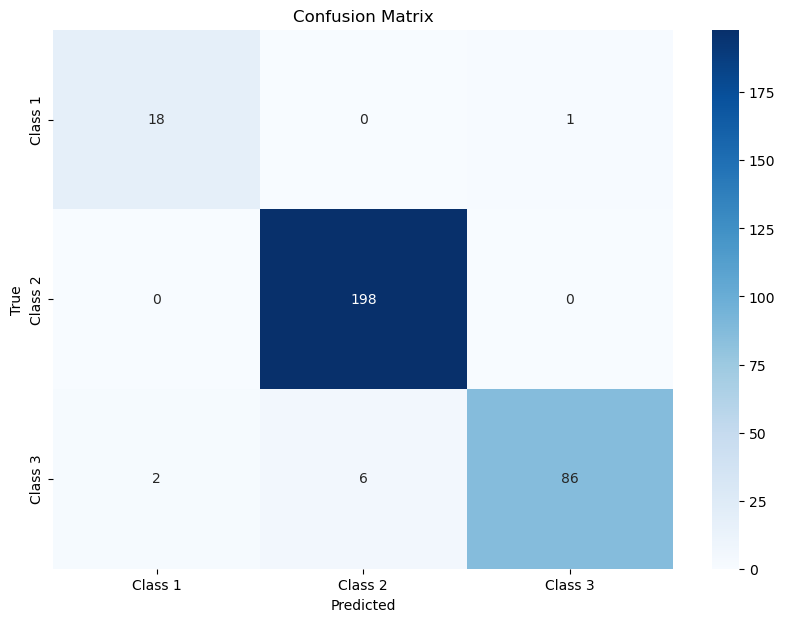

In [27]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
single_image = X_test[0]
single_image_batch = np.expand_dims(single_image, axis=0)  # Shape will be (1, 100, 100, 3)

In [29]:
single_image_prediction = model.predict(single_image_batch)

1/1 [==============================] - 0s 19ms/step


In [30]:
print(tf.argmax(single_image_prediction, axis=1))

tf.Tensor([2], shape=(1,), dtype=int64)


In [31]:
print(y_test[0])

[0. 0. 1.]


In [32]:
squeezed = np.squeeze(single)

In [33]:
print(squeezed.shape)

(4356,)


In [34]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy)


10/10 [==============================] - 0s 1ms/step - loss: 0.1072 - accuracy: 0.9711
Test accuracy: 0.971061110496521
